In [10]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

set_log_level("ERROR")

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.optimizers import Adam

In [12]:
# Get data
ds1 = pd.read_csv('../BBCA.JK.csv')
ds2 = pd.read_csv('../BBRI.JK.csv')
ds3 = pd.read_csv('../BMRI.JK.csv')

ds = ds3
ds.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-31,3800.0,3887.5,3775.0,3837.5,3051.898926,173453000
1,2019-06-03,3837.5,3837.5,3837.5,3837.5,3051.898926,0
2,2019-06-04,3837.5,3837.5,3837.5,3837.5,3051.898926,0
3,2019-06-05,3837.5,3837.5,3837.5,3837.5,3051.898926,0
4,2019-06-06,3837.5,3837.5,3837.5,3837.5,3051.898926,0


In [13]:
print(ds1['Date'].min())
print(ds1['Date'].max())
print(ds2['Date'].min())
print(ds2['Date'].max())
print(ds3['Date'].min())
print(ds3['Date'].max())

2019-05-31
2024-05-30
2019-05-31
2024-05-30
2019-05-31
2024-05-30


EDA

In [14]:
# Check for missing values from the datasets
print(len(ds))
print(len(ds2))
print(len(ds3))

print(ds.isnull().sum())
print(ds2.isnull().sum())
print(ds3.isnull().sum())

1215
1215
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


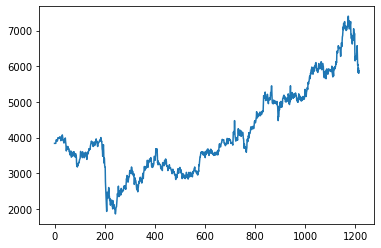

In [15]:
plt.plot(ds.Close)

In [16]:
# Check for missing value
print(ds.isnull().sum())
print(len(ds))

# Handle missing value if there's any with forward fill
ds.fillna(value='ffil', inplace=True)
print(ds.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
1215
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [17]:
# Take date and close as dataset
ds = ds[['Date', 'Close']]
ds

,Date,Close
0,2019-05-31,3837.5
1,2019-06-03,3837.5
2,2019-06-04,3837.5
3,2019-06-05,3837.5
4,2019-06-06,3837.5
...,...,...
1210,2024-05-22,6050.0
1211,2024-05-27,5825.0
1212,2024-05-28,5950.0
1213,2024-05-29,5800.0


In [18]:
print(ds['Close'].min())
print(ds['Close'].max())

1860.0
7400.0


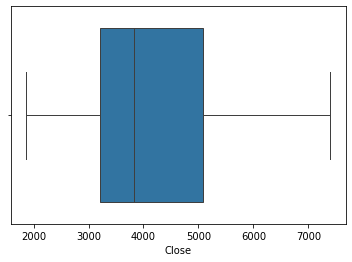

In [19]:
# Box plot to check for outliers
import seaborn as sns

sns.boxplot(x=ds['Close'])
plt.show()

# Proposed Ensemble NP-Trans

In [20]:
# Set dataset for neuralprophet by renaming the columns
ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})
ds_np

,ds,y
0,2019-05-31,3837.5
1,2019-06-03,3837.5
2,2019-06-04,3837.5
3,2019-06-05,3837.5
4,2019-06-06,3837.5
...,...,...
1210,2024-05-22,6050.0
1211,2024-05-27,5825.0
1212,2024-05-28,5950.0
1213,2024-05-29,5800.0


In [21]:
# # change data split size:
# test_size = -30
# valid_size = -495

# ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]
# train_len = len(ds_np_train)
# val_len = len(ds_np_val)
# total_train = train_len + val_len
# print(len(ds_np_train))
# print(len(ds_np_val))
# print(len(ds_np_test))

In [22]:
# Data split with ratio
test_ratio = 0.1
valid_ratio = 0.4

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))
valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

print(test_size)
print(valid_size)

# Split the dataset into training, validation, and test sets
ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

train_len = len(ds_np_train)
val_len = len(ds_np_val)
total_train = train_len + val_len

# Print lengths to verify
print(len(ds_np_train), len(ds_np_val), len(ds_np_test))

-122
-608
607 486 122


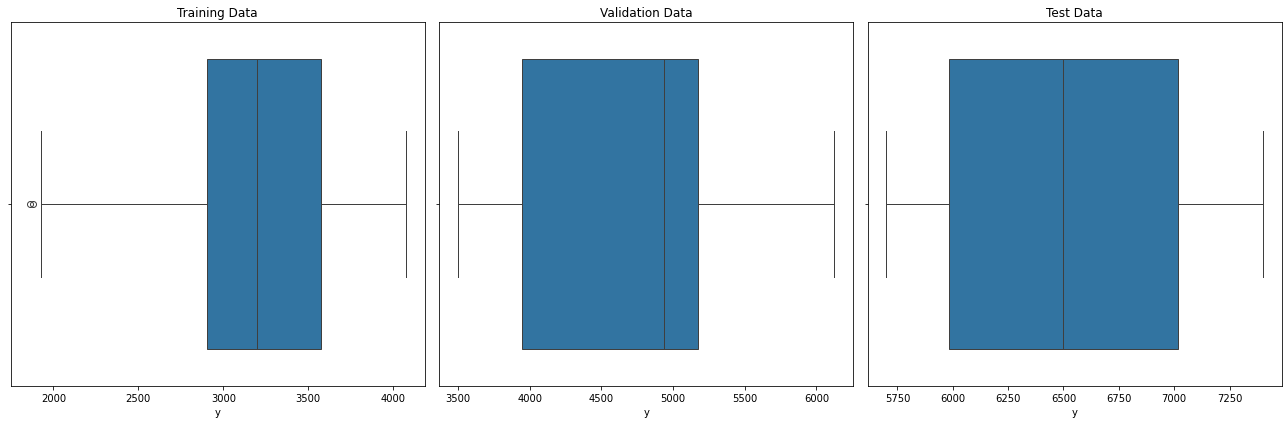

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# training data box plot
sns.boxplot(ax=axes[0], x=ds_np_train['y'])
axes[0].set_title('Training Data')

# validation data box plot
sns.boxplot(ax=axes[1], x=ds_np_val['y'])
axes[1].set_title('Validation Data')

# test data box plot
sns.boxplot(ax=axes[2], x=ds_np_test['y'])
axes[2].set_title('Test Data')

# # Set a common y-label
# fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

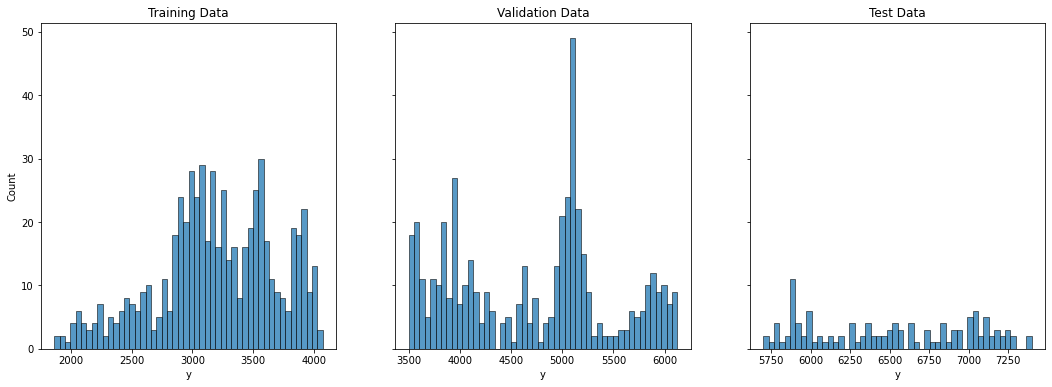

In [24]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(ds_np_train['y'], ax=axes[0], bins=50)
axes[0].set_title('Training Data')

sns.histplot(ds_np_val['y'], ax=axes[1], bins=50)
axes[1].set_title('Validation Data')

sns.histplot(ds_np_test['y'], ax=axes[2], bins=50)
axes[2].set_title('Test Data')

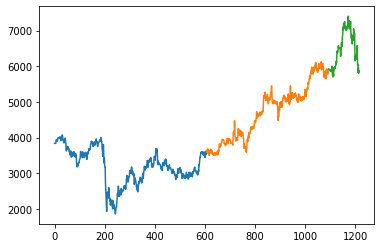

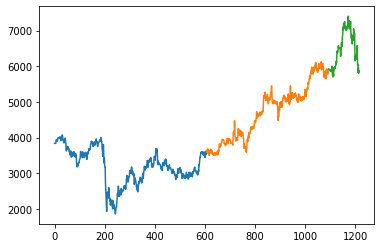

In [25]:
# plt.subplot(1, 2, 1)
plt.plot(ds.Close[:valid_size])
plt.plot(ds.Close[valid_size:test_size])
plt.plot(ds.Close[test_size:])
plt.show()

# plt.subplot(1, 2, 2)
plt.plot(ds_np_train.y)
plt.plot(ds_np_val.y)
plt.plot(ds_np_test.y)

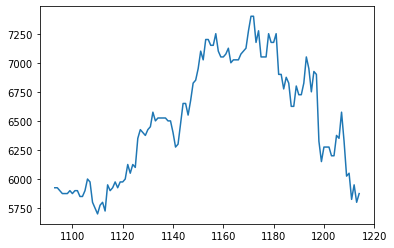

variance: 248065.98021948244
standar deviation: 498.0622252484949
mean: 6505.737704918033
cv: 0.07655737870771875


In [26]:
# Check variance of the dataset (is this the reason of the bad R2)
plt.plot(ds.Close[test_size:])
plt.show()

# plt.plot(ds_np_test.y)

variance = ds.Close[test_size:].var()
std = ds.Close[test_size:].std()
mean = ds.Close[test_size:].mean()
print(f'variance: {variance}')
print(f'standar deviation: {std}')
print(f'mean: {mean}')
print(f'cv: {std/mean}')

## NeuralProphet

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 241.21it/s]


Epoch 130: 100%|██████████| 130/130 [00:00<00:00, 1314.64it/s, loss=0.00135, v_num=401, MAE_val=53.20, RMSE_val=73.20, Loss_val=0.00209, RegLoss_val=0.000, MAE=51.00, RMSE=67.60, Loss=0.00133, RegLoss=0.000]  


,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,9392.796875,9682.360352,4.398570,0.0,0,8064.960449,8429.890625,2.847096,0.0
1,6310.297363,6654.868164,2.905839,0.0,1,5766.630371,6175.249023,2.015080,0.0
2,3904.625000,4303.374023,1.743431,0.0,2,3883.267822,4305.613281,1.303150,0.0
3,2292.684570,2658.616943,0.969882,0.0,3,2434.353027,2803.665527,0.768332,0.0
4,1220.739868,1504.810181,0.462251,0.0,4,1537.125122,1805.777100,0.450552,0.0
...,...,...,...,...,...,...,...,...,...
125,53.402855,73.643715,0.002120,0.0,125,47.809124,65.504868,0.001278,0.0
126,53.347874,73.620613,0.002118,0.0,126,54.818230,71.834732,0.001691,0.0
127,53.482761,73.853981,0.002132,0.0,127,49.815777,66.461075,0.001317,0.0
128,53.011726,73.283691,0.002099,0.0,128,50.053619,66.740738,0.001314,0.0


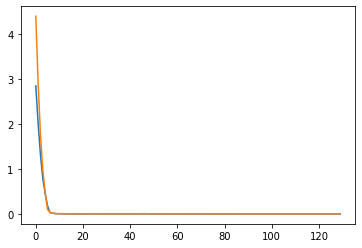

In [27]:
# Set NP model
n_lags = 2

np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = np_model.fit(ds_np_train, validation_df=ds_np_val, progress="plot")
metrics

In [28]:
# Generate prediction with val data (used to train meta model)
forecast = np_model.predict(ds_np_val)
# forecast

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


In [29]:
metrics_test = np_model.test(ds_np_val)

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         Loss_test         │   0.0020938185043632984   │
│          MAE_val          │    53.237762451171875     │
│         RMSE_val          │     73.19227600097656     │
│       RegLoss_test        │            0.0            │
└───────────────────────────┴───────────────────────────┘

In [30]:
np_model.plot(forecast)

ERROR - (NP.plotly.plot) - plotly-resampler is not installed. Please install it to use the resampler.


In [31]:
np_model.plot_components(forecast)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [32]:
forecast

,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2021-11-17,3612.5,NaN,NaN,NaN,NaN,NaN
1,2021-11-18,3587.5,NaN,NaN,NaN,NaN,NaN
2,2021-11-19,3625.0,3594.403809,2217.521240,-23.586548,260.436035,1140.032959
3,2021-11-22,3675.0,3603.858398,2238.344971,-18.032227,254.159912,1129.385742
4,2021-11-23,3575.0,3667.912598,2293.632324,-16.180664,251.875046,1138.585938
...,...,...,...,...,...,...,...
515,2023-11-08,5850.0,5887.001465,3177.835938,1307.624512,265.604248,1135.936768
516,2023-11-09,5875.0,5859.326172,3143.534424,1309.475586,266.892090,1139.423950
517,2023-11-10,5775.0,5871.377930,3152.081299,1311.327393,267.791107,1140.177856
518,2023-11-13,5825.0,5789.952637,3075.739258,1316.881348,268.283630,1129.048340


In [33]:
print(f"MAE: {mean_absolute_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast['y'][n_lags:], forecast['yhat1'][n_lags:])}")

MAE: 53.237758899484625
RMSE: 73.19227569271284
R2: 0.9906868522727427


In [34]:
# Check test data (not used)

# forecast_test = np_model.predict(ds_np_test)
# metrics_test2 = np_model.test(ds_np_test)

# np_model.plot(forecast_test)

# np_model.plot_components(forecast_test)

# print(f"MAE: {mean_absolute_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"RMSE: {root_mean_squared_error(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")
# print(f"R2: {r2_score(forecast_test['y'][n_lags:], forecast_test['yhat1'][n_lags:])}")

## Transformer

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import tensorflow as tf
from keras import layers
# from keras.layers import MultiHeadAttention, 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [36]:
# close_prices = ds['Close'].values.reshape(-1,1)
# scler = MinMaxScaler()
# close_prices = scler.fit_transform(close_prices)

In [37]:
# Define window size and number of features
window_size = 10
num_features = 1  # close price

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train, x_val, x_test = X[:valid_size], X[valid_size:test_size], X[test_size:]
y_train, y_val, y_test = y[:valid_size], y[valid_size:test_size], y[test_size:]

print(len(x_train), len(x_val), len(x_test))
print(len(y_train), len(y_val), len(y_test))
print(x_train.shape)
print(y_train.shape)

597 486 122
597 486 122
(597, 10)
(597,)


In [38]:
x_train[0]

array([3837.5, 3837.5, 3837.5, 3837.5, 3837.5, 3837.5, 3925. , 3937.5,
       3937.5, 3912.5])

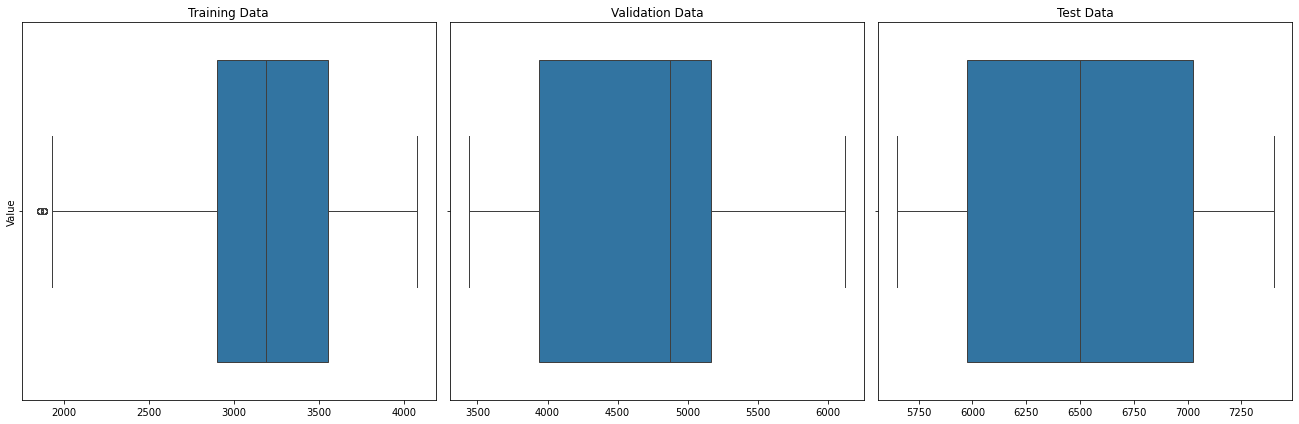

In [39]:
# plt.plot(x_train.flatten(), label='Training Data')
# plt.legend()
# plt.show()

# Outlier detection
# Flatten the data to make it suitable for plotting with boxplot
x_train_flat = x_train.flatten()
x_val_flat = x_val.flatten()
x_test_flat = x_test.flatten()

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Create a box plot for the training data
sns.boxplot(ax=axes[0], x=x_train_flat)
axes[0].set_title('Training Data')

# Create a box plot for the validation data
sns.boxplot(ax=axes[1], x=x_val_flat)
axes[1].set_title('Validation Data')

# Create a box plot for the test data
sns.boxplot(ax=axes[2], x=x_test_flat)
axes[2].set_title('Test Data')

# Set a common y-label
fig.text(0, 0.5, 'Value', va='center', rotation='vertical')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Test Data')

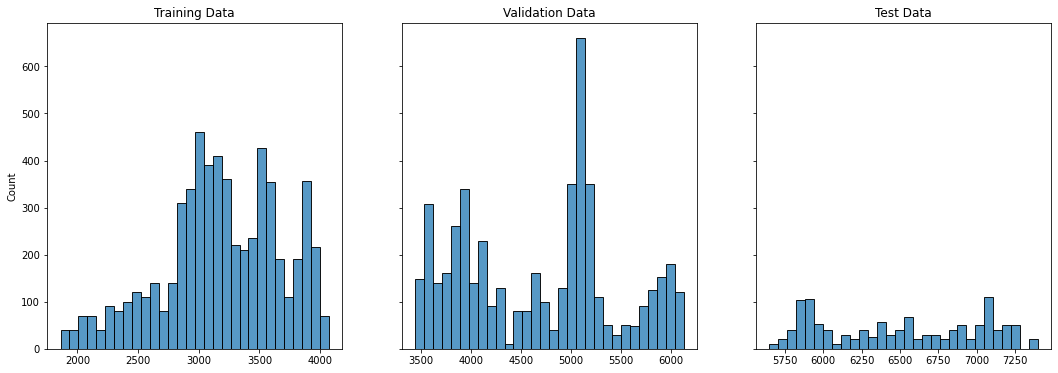

In [40]:
# Plot histograms for each split
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(x_train_flat, ax=axes[0], bins=30)
axes[0].set_title('Training Data')

sns.histplot(x_val_flat, ax=axes[1], bins=30)
axes[1].set_title('Validation Data')

sns.histplot(x_test_flat, ax=axes[2], bins=30)
axes[2].set_title('Test Data')

In [41]:
# Tried adding normalization to solve the bad R2 score when predicting the test set
# Result: adding normalization result in worse evaluation seen from the MAE, RMSE, and R2

# # Normalize the data using MinMaxScaler
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_val = scaler.transform(x_val.reshape(-1, 1)).reshape(-1, window_size, num_features)
# x_test = scaler.transform(x_test.reshape(-1, 1)).reshape(-1, window_size, num_features)


In [42]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  # n_timesteps, n_features, n_outputs = 5, 1, 5 
  inputs = tf.keras.Input(shape=(window_size, num_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(1, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

# transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)
transformer = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)

# transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#     metrics=["mae", 'mape'],
# )
transformer.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [43]:
class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'position': self.pos_encoding.shape[0],
            'd_model': self.pos_encoding.shape[1],
        })
        return config

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                                     np.arange(d_model)[np.newaxis, :],
                                     d_model)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [44]:
# def transformer_encoder2(inputs, head_size, num_heads, ff_dim,
#                         dropout=0):
#   x = layers.LayerNormalization(epsilon=1e-6)(inputs)
#   x = layers.MultiHeadAttention(
#       key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
#   x = layers.Dropout(dropout)(x)
#   res = x + inputs
  
#   # Feed Forward Part
#   x = layers.LayerNormalization(epsilon=1e-6)(res)
#   x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
#   x = layers.Dropout(dropout)(x)
#   x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#   return x + res

# def build_transfromer2(head_size, 
#                       num_heads,
#                       ff_dim,
#                       num_trans_blocks,
#                       mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
#   inputs = tf.keras.Input(shape=(window_size, num_features))
#   x = PositionalEncoding(window_size,num_features)(inputs) 
#   for _ in range(num_trans_blocks):
#     x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
#   x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
#   for dim in mlp_units:
#     x = layers.Dense(dim, activation="relu")(x)
#     x = layers.Dropout(mlp_dropout)(x)

#   outputs = layers.Dense(1, activation='linear')(x)
#   return tf.keras.Model(inputs, outputs)

# transformer2 = build_transfromer2(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], 
#                                 mlp_dropout=0.10, dropout=0.10)

# # transformer.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
# #     metrics=["mae", 'mape'],
# # )
# transformer2.compile(loss="mse", optimizer='adam', metrics=["mae", 'mape'])

# callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [45]:
histT = transformer.fit(x_train, y_train, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 10799123.0000 - mae: 2950.3708 - mape: 93.5886

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 10522197.0000 - mae: 2893.1023 - mape: 91.7596
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 990751.7500 - mae: 884.2993 - mape: 27.7268 
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 212009.1094 - mae: 361.3824 - mape: 11.5402
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 141597.4219 - mae: 293.0231 - mape: 9.5386
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 132842.2344 - mae: 283.6765 - mape: 9.0377
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 138404.9062 - mae: 280.6100 - mape: 8.9690
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 127599.5234 - mae: 281.7134 - mape: 9.0640
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 127242.6562 - mae: 283.7750 - mape: 9.0182
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 125743.2891 - mae: 279.6187 - mape: 9.0213
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 123871.9141 - mae: 274.810

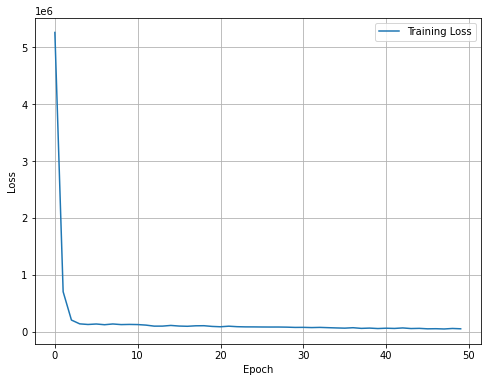

In [46]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT.history['loss'], label='Training Loss')
# plt.plot(histT.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [47]:
# histT2 = transformer2.fit(x_train, y_train, batch_size=32, epochs=50,
#                          verbose=1, callbacks=callbacks)

In [48]:
prediction = transformer.predict(x_val)
# prediction2 = transformer2.predict(x_val)

print("TRANSFORMER EVALUATION METRICS")
# mse1 = np.mean((prediction - y_val)**2)
# rmse1 = np.sqrt(mse1)
# mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# print('MSE: ', mse1)
# print('RMSE: ', rmse1)
# print('MAPE: ', mape)

print(f"MAE: {mean_absolute_error(prediction, y_val)}")
print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# # print(f"MSE: {mean_squared_error(prediction2, y_val)}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
TRANSFORMER EVALUATION METRICS
MAE: 94.34861020688658
RMSE: 121.774404149399
R2: 0.9766937815416369


##### testing stuff

In [49]:
# predTrain = transformer.predict(x_train)

# print(f"MAE: {mean_absolute_error(predTrain, y_train)}")
# print(f"RMSE: {root_mean_squared_error(predTrain, y_train)}")
# print(f"R2: {r2_score(predTrain, y_train)}")
# print(f"R2: {mean_squared_error(predTrain, y_train)}")

In [50]:
# # prediction = scler.inverse_transform(prediction)
# # prediction2 = scler.inverse_transform(prediction2)

# print("TRANSFORMER EVALUATION METRICS")
# # mse1 = np.mean((prediction - y_val)**2)
# # rmse1 = np.sqrt(mse1)
# # mape = np.mean(np.abs((y_val - prediction) / y_val)) * 100

# # print('MSE: ', mse1)
# # print('RMSE: ', rmse1)
# # print('MAPE: ', mape)

# print(f"MAE: {mean_absolute_error(prediction, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction, y_val)}")
# print(f"R2: {r2_score(prediction, y_val)}")
# print(f"MSE: {mean_squared_error(prediction, y_val)}")

# print("TRANSFORMER 2 EVALUATION METRICS")
# print(f"MAE: {mean_absolute_error(prediction2, y_val)}")
# print(f"RMSE: {root_mean_squared_error(prediction2, y_val)}")
# print(f"R2: {r2_score(prediction2, y_val)}")
# print(f"MSE: {mean_squared_error(prediction2, y_val)}")

In [51]:
# Check test data (not used)

# testPrd = transformer.predict(x_test)
# testPrd2 = transformer2.predict(x_test)

# print(f"MAE: {mean_absolute_error(testPrd, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd, y_test)}")
# print(f"R2: {r2_score(testPrd, y_test)}")

# print(f"MAE: {mean_absolute_error(testPrd2, y_test)}")
# print(f"RMSE: {root_mean_squared_error(testPrd2, y_test)}")
# print(f"R2: {r2_score(testPrd2, y_test)}")

# plt.plot(y_test, 'g')
# plt.plot(testPrd, 'b')
# plt.plot(testPrd2, 'r')
# # plt.plot(forecast['yhat1'], 'y')
# plt.legend(['Actual', 'Prediction Transformer', 'Pred Transformer2'])

# print(np.mean(y_test))
# print(np.mean(testPrd))

### Transformer graph and result

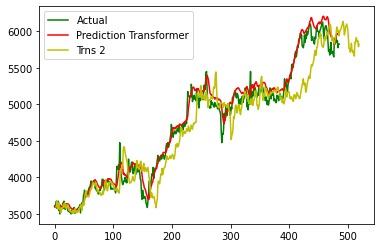

In [52]:
plt.plot(y_val, 'g')
plt.plot(prediction, 'r')
# plt.plot(prediction2, 'b')
plt.plot(forecast['yhat1'], 'y')
plt.legend(['Actual', 'Prediction Transformer', 'Trns 2', 'NP'])

# notes: the neuralprophet prediction is more compared to the actual and transformer as there are inputs of data from the model itself

# Stack/Hybrid

In [53]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

In [54]:
# Combine data prediction result of base models
np_pred = forecast[forecast['ds'].isin(ds_np_val['ds'])].reset_index()
np_pred = np_pred['yhat1']

x_train_meta = np.column_stack((np_pred[n_lags:], prediction[n_lags:]))

In [55]:
print(f"train: {x_train_meta[:10]}")
print(f"label: {y_val[:10]}")

train: [[3594.4038 3596.2485]
 [3603.8584 3615.477 ]
 [3667.9126 3643.2144]
 [3594.4146 3633.0498]
 [3572.9497 3630.5098]
 [3651.3755 3648.6343]
 [3564.0952 3628.9763]
 [3585.4175 3623.7124]
 [3514.8528 3614.9146]
 [3530.7136 3597.9927]]
label: [3612.5 3587.5 3625.  3675.  3575.  3575.  3675.  3550.  3587.5 3500. ]


In [56]:
# Set meta model
meta_model = LinearRegression()
# meta_model = RandomForestRegressor(n_estimators=2)
print('Linear Regression Train')
meta_model.fit(x_train_meta, y_val[n_lags:])


meta_model2 = Sequential()
meta_model2.add(Dense(8, input_dim=x_train_meta.shape[1], activation='relu'))
meta_model2.add(Dropout(0.1))
meta_model2.add(Dense(16, activation='relu'))
# meta_model2.add(Dropout(0.2))
meta_model2.add(Dense(1, activation='linear'))
print('MLP Train')
meta_model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
meta_model2.fit(x_train_meta, y_val[n_lags:], epochs=20, batch_size=32, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=1)

# meta_model3 = LogisticRegression(random_state=0)
# meta_model3.fit(x_train_meta, y_val[n_lags:])

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Linear Regression Train
MLP Train
Epoch 1/20
 1/16 ━━━━━━━━━━━━━━━━━━━━ 9s 632ms/step - loss: 38025820.0000 - mae: 6074.2383 - mape: 126.2932

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 873us/step - loss: 35377584.0000 - mae: 5855.1060 - mape: 124.2845
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 29739832.0000 - mae: 5376.8154 - mape: 113.7539
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 24979820.0000 - mae: 4928.2954 - mape: 104.4811
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 20548230.0000 - mae: 4464.9082 - mape: 94.7899
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 15773471.0000 - mae: 3911.2307 - mape: 83.1259
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 10346129.0000 - mae: 3140.3838 - mape: 66.9599
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 5557050.0000 - mae: 2240.0515 - mape: 47.5470
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 2920507.7500 - mae: 1461.6879 - mape: 31.2328
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1440790.8750 - mae: 763.7219 - mape: 16.1236
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/s

#### Final Prediction

In [57]:
# Use test data to make final prediction
# make prediction with base model
np_y_pred = np_model.predict(ds_np_test)
tf_y_pred = transformer.predict(x_test)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.98it/s] 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [58]:
# Combine test data
np_y_pred = np_y_pred[np_y_pred['ds'].isin(ds_np_test['ds'])].reset_index()
np_y_pred = np_y_pred['yhat1']

x_test_meta = np.column_stack((np_y_pred[n_lags:], tf_y_pred[n_lags:]))

In [59]:
# Predict test data with meta model
final_pred = meta_model.predict(x_test_meta)
final_pred2 = meta_model2.predict(x_test_meta)
# final_pred3 = meta_model3.predict(x_test_meta)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [60]:
print(range(train_len, len(ds)-n_lags))
print(len(ds))
print(val_len)
print(len(y_test[n_lags:]))

range(607, 1213)
1215
486
120


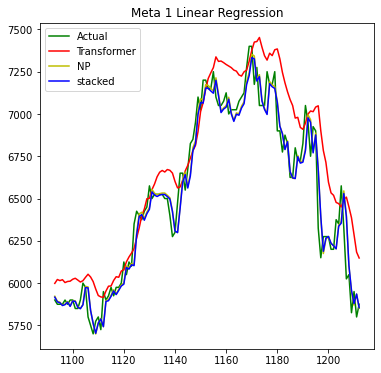

In [61]:
# Plot Prediction
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='stacked')
plt.title('Meta 1 Linear Regression')
plt.legend()

In [62]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 77.550439453125
RMSE: 108.43112222441646
R2: 0.9496946798728295
Transformer Evaluation
MAE: 186.14398193359375
RMSE: 237.13187642807804
R2: 0.7746306080944256
Meta Evaluation
MAE: 78.96999104817708
RMSE: 109.6750408483883
R2: 0.947627307303


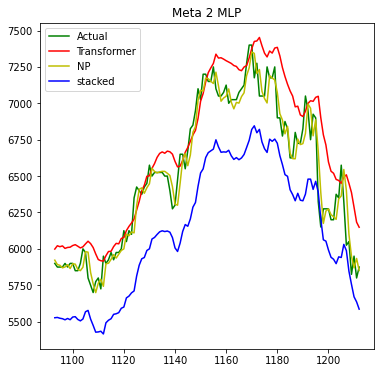

In [63]:
# Plot Predictions
fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred2, 'b', label='stacked')
plt.title('Meta 2 MLP')
plt.legend()

In [64]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")
print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")
print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred2, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred2, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred2, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 77.550439453125
RMSE: 108.43112222441646
R2: 0.9496946798728295
Transformer Evaluation
MAE: 186.14398193359375
RMSE: 237.13187642807804
R2: 0.7746306080944256
Meta Evaluation
MAE: 398.573974609375
RMSE: 420.6829671014934
R2: 0.13637210618992268


### Single Models

## Single NP

In [65]:
# Data split with ratio
test_ratio = 0.1

# Calculate size of split based on ratio
test_size = -1 * round(test_ratio * len(ds_np))

# Split the dataset into training, validation, and test sets
ds_np_train2, ds_np_test2 = ds_np[:test_size], ds_np[test_size:]

print(len(ds_np_train2), len(ds_np_test2))

1093 122


Finding best initial lr: 100%|██████████| 227/227 [00:00<00:00, 280.10it/s]


Epoch 110: 100%|██████████| 110/110 [00:00<00:00, 846.39it/s, loss=0.000464, v_num=402, MAE=55.10, RMSE=75.20, Loss=0.000474, RegLoss=0.000]   


,MAE,RMSE,Loss,RegLoss,epoch
0,13680.253906,15095.420898,2.637137,0.0,0
1,7697.324219,8858.940430,1.444601,0.0,1
2,3936.724609,4730.148438,0.682649,0.0,2
3,2032.047974,2505.013184,0.298843,0.0,3
4,1012.113159,1227.529785,0.108060,0.0,4
...,...,...,...,...,...
105,54.689655,74.991074,0.000472,0.0,105
106,55.071323,75.037971,0.000472,0.0,106
107,54.591125,74.917534,0.000471,0.0,107
108,55.342499,76.191689,0.000484,0.0,108


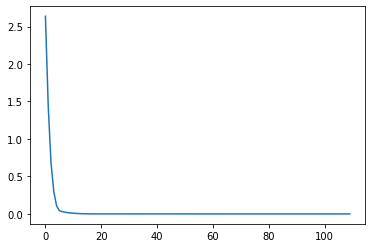

In [66]:
n_lags = 2

single_np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
)

# Train NP 
metrics = single_np_model.fit(ds_np_train2, progress="plot")
metrics

In [67]:
forecast2 = np_model.predict(ds_np_test2)
forecast2

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.92it/s]


,ds,y,yhat1,ar1,trend,season_yearly,season_weekly
0,2023-11-15,5925.0,NaN,NaN,NaN,NaN,NaN
1,2023-11-16,5925.0,NaN,NaN,NaN,NaN,NaN
2,2023-11-17,5900.0,5922.283203,3194.307861,1324.287598,264.607391,1139.080322
3,2023-11-20,5875.0,5892.316895,3174.369629,1329.842041,259.468018,1128.637329
4,2023-11-21,5875.0,5887.079590,3157.332275,1331.693726,257.438782,1140.614868
...,...,...,...,...,...,...,...
137,2024-05-24,5900.0,6000.974121,3565.736084,1674.216675,-376.391754,1137.413208
138,2024-05-27,5825.0,5948.939453,3480.055420,1679.770630,-341.362244,1130.475342
139,2024-05-28,5950.0,5869.780273,3377.003906,1681.622314,-328.987396,1140.141479
140,2024-05-29,5800.0,5934.225586,3431.438477,1683.473511,-316.369293,1135.682495


In [68]:
np_model.plot_components(forecast2)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.


In [69]:
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

MAE: 75.3408427335778
RMSE: 105.95417081932831
R2: 0.952790580613641


## Single Trans

In [70]:
# Define window size and number of features
window_size = 10
num_features = 1

# make input sequences
X = []
y = []
for i in range(len(ds['Close']) - window_size):
    X.append(ds['Close'][i:i+window_size])
    y.append(ds['Close'][i+window_size])

# lists to arrays
X, y = np.array(X), np.array(y)

x_train2, x_test2 = X[:test_size], X[test_size:]
y_train2, y_test2 = y[:test_size], y[test_size:]

# standarization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

x_train2 = scaler_X.fit_transform(x_train2)
y_train2 = scaler_y.fit_transform(y_train2.reshape(-1, 1)).flatten()

# Use the same transformation on the test data
x_test2 = scaler_X.transform(x_test2)
y_test2 = scaler_y.transform(y_test2.reshape(-1, 1)).flatten()


In [71]:
transformer2 = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)


transformer2.compile(loss="mse", optimizer=Adam(learning_rate=0.0001), metrics=["mae", 'mape'])

callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [72]:
histT2 = transformer2.fit(x_train2, y_train2, batch_size=32, epochs=50,
                         verbose=1, callbacks=callbacks)

prediction2 = transformer2.predict(x_test2)


Epoch 1/50
33/34 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.7465 - mae: 0.6857 - mape: 142.7508

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.7383 - mae: 0.6817 - mape: 145.0547
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.3823 - mae: 0.4848 - mape: 201.7189
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1634 - mae: 0.3021 - mape: 73.0065
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0547 - mae: 0.1817 - mape: 108.4118
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0332 - mae: 0.1354 - mape: 98.6980
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0272 - mae: 0.1264 - mape: 78.9072
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0301 - mae: 0.1231 - mape: 64.4869
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0258 - mae: 0.1199 - mape: 62.0450
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0278 - mae: 0.1203 - mape: 56.3906
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0236 - mae: 0.1107 - mape: 57.3855
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/

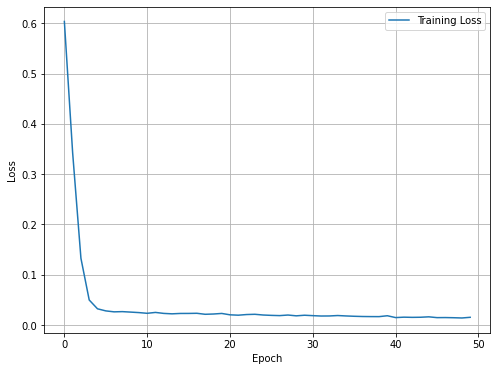

In [73]:
# Graph loss training
plt.figure(figsize=(8, 6))
plt.plot(histT2.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [74]:
prediction2 = prediction2.reshape(-1, 1)
prediction2 = scaler_y.inverse_transform(prediction2)

y_test2 = scaler_y.inverse_transform(y_test2.reshape(-1, 1))

print("TRANSFORMER EVALUATION METRICS")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

TRANSFORMER EVALUATION METRICS
MAE: 119.21688892802254
RMSE: 160.97582369773124
R2: 0.8890511818439163


In [75]:
print("Evaluation metrics between models of:")
print("\nProposed Ensemble Np-Trans")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

print("\nNeuralProphet")
print(f"MAE: {mean_absolute_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")
print(f"R2: {r2_score(forecast2['y'][n_lags:], forecast2['yhat1'][n_lags:])}")

print("\nTransformer")
print(f"MAE: {mean_absolute_error(prediction2, y_test2)}")
print(f"RMSE: {root_mean_squared_error(prediction2, y_test2)}")
print(f"R2: {r2_score(prediction2, y_test2)}")

Evaluation metrics between models of:

Proposed Ensemble Np-Trans
MAE: 78.96999104817708
RMSE: 109.6750408483883
R2: 0.947627307303

NeuralProphet
MAE: 75.3408427335778
RMSE: 105.95417081932831
R2: 0.952790580613641

Transformer
MAE: 119.21688892802254
RMSE: 160.97582369773124
R2: 0.8890511818439163


In [76]:
# the result of neuralprohet has some additional data of dates, so we will take only the date that's on the y
forecast2 = forecast2[forecast2['ds'].isin(ds_np_test2['ds'])].reset_index()


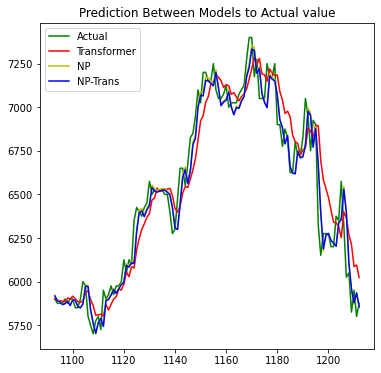

In [77]:
# Plot Prediction

fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test2[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), prediction2[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), forecast2['yhat1'][n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='NP-Trans')
plt.title('Prediction Between Models to Actual value')
plt.legend()

In [78]:
print('Neural Prophet Evaluation')
# print(f"MSE: {mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(forecast2['yhat1'][n_lags:], y_test[n_lags:])}")

print('Transformer Evaluation')
# print(f"MSE: {mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

print('Meta Evaluation')
# print(f"MSE: {mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

Neural Prophet Evaluation
MAE: 77.550439453125
RMSE: 108.43112222441646
R2: 0.9496946798728295
Transformer Evaluation
MAE: 186.14398193359375
RMSE: 237.13187642807804
R2: 0.7746306080944256
Meta Evaluation
MAE: 78.96999104817708
RMSE: 109.6750408483883
R2: 0.947627307303


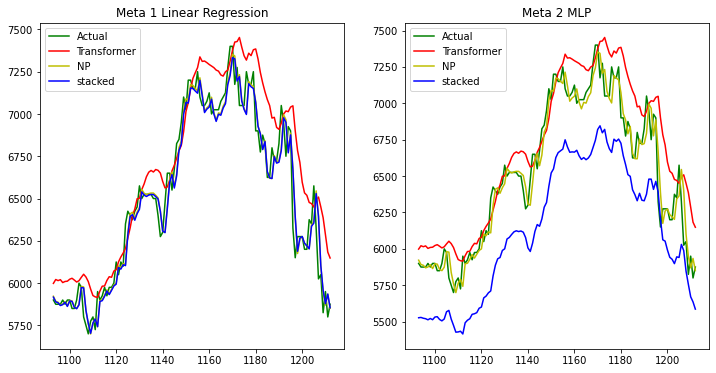

In [79]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)

# Plot Prediction
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred, 'b', label='stacked')
plt.title('Meta 1 Linear Regression')
plt.legend()

plt.subplot(1,2,2)
# Plot Predictions
# fig = plt.figure(figsize=(6, 6))
plt.plot(range(total_train, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
plt.plot(range(total_train, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer")
plt.plot(range(total_train, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP')
plt.plot(range(total_train, len(ds)-n_lags), final_pred2, 'b', label='stacked')
plt.title('Meta 2 MLP')
plt.legend()

plt.show()

# Tidy

In [80]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import matplotlib.pyplot as plt

set_log_level("ERROR")

import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from keras.optimizers import Adam
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression

In [81]:
def data_process(ds):
    ds.fillna(value='ffil', inplace=True)
    ds = ds[['Date', 'Close']]

    ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})

    # Data split with ratio
    test_ratio = 0.1
    valid_ratio = 0.4

    # Calculate size of split based on ratio
    test_size = -1 * round(test_ratio * len(ds_np))
    valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

    # Split the dataset into training, validation, and test sets
    ds_np_train, ds_np_val, ds_np_test = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

    train_len = len(ds_np_train)
    val_len = len(ds_np_val)
    total_train = train_len + val_len

    # Print lengths to verify
    print(len(ds_np_train), len(ds_np_val), len(ds_np_test))
    return ds_np_train, ds_np_val, ds_np_test, test_size, valid_size

def data_process_2(ds, window_size, num_features):
    # make input sequences
    X = []
    y = []
    for i in range(len(ds['Close']) - window_size):
        X.append(ds['Close'][i:i+window_size])
        y.append(ds['Close'][i+window_size])

    # lists to arrays
    X, y = np.array(X), np.array(y)

    x_train, x_val, x_test = X[:valid_size], X[valid_size:test_size], X[test_size:]
    y_train, y_val, y_test = y[:valid_size], y[valid_size:test_size], y[test_size:]

    print(len(x_train), len(x_val), len(x_test))
    print(len(y_train), len(y_val), len(y_test))
    print(x_train.shape)
    print(y_train.shape)
    return x_train, x_val, x_test, y_train, y_val, y_test

def data_process_3(np_y_pred, tf_y_pred, n_lags, ds_np, np_flag):
    print("before processing np_pred")
    print(np.shape(np_y_pred))
    np_pred = np_y_pred[np_y_pred['ds'].isin(ds_np['ds'])].reset_index()
    np_pred = np_pred['yhat1']
    print("function:")
    print(np.shape(np_pred))
    print(np.shape(tf_y_pred))
    x_train_meta = np.column_stack((np_pred[n_lags:], tf_y_pred[n_lags:]))

    if np_flag == 0:
        return x_train_meta
    else:
        return x_train_meta, np_pred

In [82]:
def base_model_np(n_lags, ds_np_train, ds_np_val):
  np_model = NeuralProphet(
    n_changepoints=2,
    n_lags=n_lags,
    drop_missing=True,
  )

  # Train NP 
  metrics = np_model.fit(ds_np_train, validation_df=ds_np_val, progress="plot")
  metrics

  return np_model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
  # Creates a single transformer block.
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  
  # Creates final model by building many transformer blocks.
  
  inputs = tf.keras.Input(shape=(window_size, num_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(1, activation='linear')(x)
  return tf.keras.Model(inputs, outputs)

def base_model_tf(x_train, y_train, n_batch_size, n_epochs):
  transformer = build_transfromer(head_size=40, num_heads=60, ff_dim=60, num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10)

  transformer.compile(loss="mse", optimizer="adam", metrics=["mae", "mape"])
  callbacks = EarlyStopping(patience=10, restore_best_weights=True)

  history = transformer.fit(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs, verbose=1, callbacks=callbacks)

  return transformer

In [83]:
def graph_np_trans(total_len, ds, n_lags, y_test, np_y_pred, tf_y_pred, final_pred, stock_name):
    fig = plt.figure(figsize=(6, 6))
    plt.plot(range(total_len, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
    plt.plot(range(total_len, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer Base")
    plt.plot(range(total_len, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP Base')
    plt.plot(range(total_len, len(ds)-n_lags), final_pred, 'b', label='Meta')
    plt.title(f'Meta vs Base Prediction of {stock_name}')
    plt.legend()
    plt.show()

In [84]:
def graph_np_trans2(axis, total_len, ds, n_lags, y_test, np_y_pred, tf_y_pred, final_pred, stock_name):
    axis.cla()
    
    axis.plot(range(total_len, len(ds)-n_lags), y_test[n_lags:], 'g-', label="Actual")
    axis.plot(range(total_len, len(ds)-n_lags), tf_y_pred[n_lags:], 'r', label="Transformer Base")
    axis.plot(range(total_len, len(ds)-n_lags), np_y_pred[n_lags:], 'y', label='NP Base')
    axis.plot(range(total_len, len(ds)-n_lags), final_pred, 'b', label='Meta')
    
    axis.set_title(stock_name)
    # axis.set_xlim(total_len, len(ds)-n_lags)

In [85]:
def evaluate(y_test, np_y_pred, tf_y_pred, final_pred, n_lags, stock_name):
    print(f'Evaluation results of {stock_name}')

    print('Neural Prophet Evaluation')
    print(f"MAE: {mean_absolute_error(np_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(np_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"R2: {r2_score(np_y_pred[n_lags:], y_test[n_lags:])}")

    print('Transformer Evaluation')
    print(f"MAE: {mean_absolute_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(tf_y_pred[n_lags:], y_test[n_lags:])}")
    print(f"R2: {r2_score(tf_y_pred[n_lags:], y_test[n_lags:])}")

    print('Meta Evaluation')
    print(f"MAE: {mean_absolute_error(final_pred, y_test[n_lags:])}")
    print(f"RMSE: {root_mean_squared_error(final_pred, y_test[n_lags:])}")
    print(f"R2: {r2_score(final_pred, y_test[n_lags:])}")

607 486 122


Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 254.42it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 499.80it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 23034630.0000 - mae: 4184.7969 - mape: 66.4946

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 21783982.0000 - mae: 4023.8232 - mape: 63.9476
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1920703.5000 - mae: 1177.5300 - mape: 18.8850
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 644431.1250 - mae: 664.5723 - mape: 10.6588
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 381517.9688 - mae: 493.2332 - mape: 7.9656
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 324892.3750 - mae: 452.9243 - mape: 7.3105
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 370601.5000 - mae: 479.6916 - mape: 7.7412
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 278738.3438 - mae: 415.2083 - mape: 6.6684
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 340422.8750 - mae: 456.8301 - mape: 7.3425
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 298990.8750 - mae: 439.8907 - mape: 7.0731
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 310152.5000 - mae: 431.30

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 254.39it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.17it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 5411512.0000 - mae: 1994.0408 - mape: 55.1595

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 5137398.5000 - mae: 1927.5311 - mape: 53.3367
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 443531.3438 - mae: 544.8994 - mape: 15.1601
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 221494.8906 - mae: 368.5960 - mape: 10.2375
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 208846.1562 - mae: 356.5944 - mape: 9.9192
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 174435.3594 - mae: 334.1390 - mape: 9.4963
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 170696.6094 - mae: 323.1454 - mape: 9.1412
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 170581.5469 - mae: 323.0440 - mape: 9.0318
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 155334.7812 - mae: 303.7440 - mape: 8.5813
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 164086.0469 - mae: 315.2329 - mape: 8.7648
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 162864.3438 - mae: 319.0281 

Finding best initial lr: 100%|██████████| 221/221 [00:00<00:00, 260.50it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 249.94it/s]
597 486 122
597 486 122
(597, 10)
(597,)
Epoch 1/50
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 11632658.0000 - mae: 3093.5854 - mape: 96.6731

WARNING - (py.warnings._showwarnmsg) - c:\Users\ASUS TUF\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning:

Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape




19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 11017442.0000 - mae: 2967.6831 - mape: 92.7559
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 842260.1875 - mae: 817.8133 - mape: 25.2063
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 161185.7500 - mae: 307.8074 - mape: 9.5940
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 131840.1719 - mae: 292.5973 - mape: 9.2975
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 126779.3594 - mae: 280.2927 - mape: 8.8450
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 113538.0312 - mae: 259.0169 - mape: 8.2890
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 122443.3828 - mae: 272.5069 - mape: 8.5968
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 128174.0078 - mae: 276.1648 - mape: 8.7042
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 128939.9297 - mae: 276.1465 - mape: 8.8443
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 128080.6641 - mae: 285.1306 

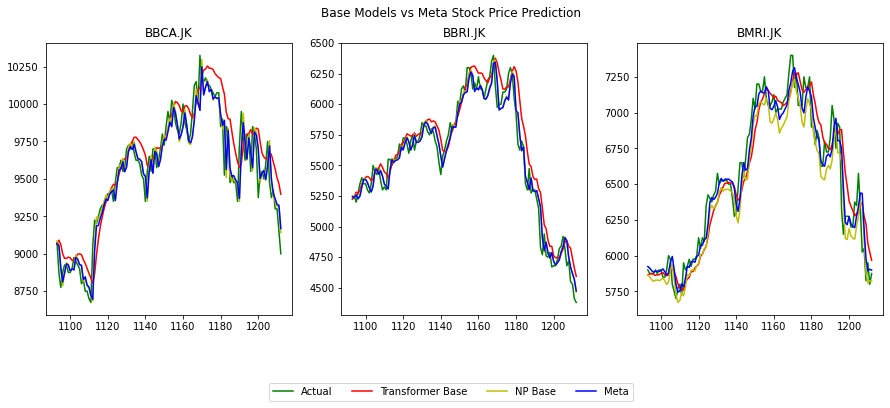

In [86]:
np_base_results = []
tf_base_results = []
meta_results = []

ds_list = ['BBCA.JK', 'BBRI.JK','BMRI.JK']
# ds_list = ['BBRI.JK','BMRI.JK']

fig, axes = plt.subplots(1, len(ds_list), figsize=(15,5), sharey=False)
fig.suptitle('Base Models vs Meta Stock Price Prediction')

for idx, i in enumerate(ds_list):
    ds = pd.read_csv(f'../{i}.csv')

    # Neural Prpohet Base Model
    np_train, np_val, np_test, test_size, valid_size = data_process(ds)
    
    total_train_len = len(np_train) + len(np_val)

    n_lags = 2
    np_base = base_model_np(n_lags, np_train, np_val)
    np_base_predict = np_base.predict(np_val)

    # Transformer Base Model
    window_size = 10
    num_features = 1
    tf_x_train, tf_x_val, tf_x_test, tf_y_train, tf_y_val, tf_y_test = data_process_2(ds, window_size, num_features)

    # head_size = 40
    # num_heads = 60
    # ff_dim = 60
    # num_trans_block = 4 
    # mlp_units = 256

    batch_size = 32
    epochs = 50

    tf_base = base_model_tf(tf_x_train, tf_y_train, batch_size, epochs)
    tf_base_predict = tf_base.predict(tf_x_val)

    # Meta Model
    meta_x_train = data_process_3(np_base_predict, tf_base_predict, n_lags, np_val, 0)
    
    meta_model = LinearRegression()
    meta_model.fit(meta_x_train, tf_y_val[n_lags:])

    np_y_pred = np_base.predict(np_test)
    tf_y_pred = tf_base.predict(tf_x_test)

    # print('=================')
    # print(np.shape(np_y_pred))
    # print(np.shape(tf_y_pred))
    
    x_test_meta, np_y_pred = data_process_3(np_y_pred, tf_y_pred, n_lags, np_test, 1)

    meta_prediction = meta_model.predict(x_test_meta)
    # graph_np_trans(total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)

    graph_np_trans2(axes[idx], total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)
    evaluate(tf_y_test, np_y_pred, tf_y_pred, meta_prediction, n_lags, i)

    # break

# Create a single legend for the whole figure
lines, labels = axes[0].get_legend_handles_labels()  # Get labels from the first subplot
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.show()

In [87]:
# print("NaNs in y_test:", np.isnan(y_test).any())
# print("NaNs in np_y_pred:", np.isnan(np_y_pred).any())
# print("NaNs in tf_y_pred:", np.isnan(tf_y_pred).any())
# print("NaNs in final_pred:", np.isnan(final_pred).any())

print(np_y_pred[n_lags:])

2      5864.908203
3      5851.833008
4      5832.259766
5      5820.772461
6      5828.139648
          ...     
117    6105.888672
118    5881.499023
119    5807.816406
120    5824.297852
121    5824.328125
Name: yhat1, Length: 120, dtype: float32


In [88]:
print(i) 
print(total_train_len)
print(len(ds))
print(n_lags)
print(len(tf_y_test))
print(len(np_y_pred))
print(len(tf_y_pred))
print(len(meta_prediction))
# graph_np_trans(total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)
graph_np_trans2(axes[idx], total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction, i)
plt.show()

BMRI.JK
1093
1215
2
122
122
122
120


In [89]:
def single_np(np_train, n_lags):

    single_np = NeuralProphet(
        n_changepoints=2,
        n_lags=n_lags,
        drop_missing=True
    )

    metrics = single_np.fit(np_train, progress="plot")

    return 

In [90]:
#Single Models

for idx, i in enumerate(ds_list):
    ds = pd.read_csv(f'../{i}.csv')   

    ds.fillna(value='ffil', inplace=True)

    # Neural Prophet
    ds = ds[['Date', 'Close']]

    ds_np = ds.rename(columns={'Date': 'ds', 'Close': 'y'})


    test_ratio = 0.1
    valid_ratio = 0.3

    test_size = -1 * round(test_ratio * len(ds_np))
    valid_size = -1 * round((valid_ratio + test_ratio) * len(ds_np))

    ds_np_train2, ds_np_val2, ds_np_test2 = ds_np[:valid_size], ds_np[valid_size:test_size], ds_np[test_size:]

    np_model = single_np(ds_np_train2, 2)
    np_forecast = np_model.predict(ds_np_test2)
    
    # Transformer
    window_size = 10
    num_features = 1

    X = []
    y = []
    for i in range(len(ds['Close']))

SyntaxError: expected ':' (1073609985.py, line 31)

In [ ]:
# import matplotlib.pyplot as plt

# # Define your function to plot predictions and actual values
# def graph_np_trans(axis, total_train_len, ds, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction):
#     axis.plot(range(total_train_len, total_train_len + len(tf_y_test)), tf_y_test, label='Actual', color='blue')
#     axis.plot(range(total_train_len, total_train_len + len(np_y_pred)), np_y_pred, label='Neural Prophet Prediction', color='green')
#     axis.plot(range(total_train_len, total_train_len + len(tf_y_pred)), tf_y_pred, label='Transformer Prediction', color='red')
#     axis.plot(range(total_train_len, total_train_len + len(meta_prediction)), meta_prediction, label='Meta Model Prediction', color='purple')
#     axis.legend()
#     axis.set_title(ds)

# # Create the figure and axes for subplots
# fig, axes = plt.subplots(1, len(ds_list), figsize=(15, 5), sharey=True)
# fig.suptitle('Stock Price Predictions for Different Models')

# # Loop through each dataset and subplot
# for idx, i in enumerate(ds_list):
#     ds = pd.read_csv(f'../{i}.csv')
    
#     # Neural Prophet Base Model
#     np_train, np_val, np_test, test_size, valid_size = data_process(ds)
#     total_train_len = len(np_train) + len(np_val)
    
#     # Set up and train Neural Prophet model
#     n_lags = 2
#     np_base = base_model_np(n_lags, np_train, np_val)
#     np_base_predict = np_base.predict(np_val)
    
#     # Transformer Base Model setup
#     window_size = 10
#     num_features = 1
#     tf_x_train, tf_x_val, tf_x_test, tf_y_train, tf_y_val, tf_y_test = data_process_2(ds, window_size, num_features)
    
#     batch_size = 32
#     epochs = 50
#     tf_base = base_model_tf(tf_x_train, tf_y_train, batch_size, epochs)
#     tf_base_predict = tf_base.predict(tf_x_val)
    
#     # Meta Model setup and predictions
#     meta_x_train = data_process_3(np_base_predict, tf_base_predict, n_lags, np_val, 0)
#     meta_model = LinearRegression()
#     meta_model.fit(meta_x_train, tf_y_val[n_lags:])
    
#     # Generate predictions for test data
#     np_y_pred = np_base.predict(np_test)
#     tf_y_pred = tf_base.predict(tf_x_test)
#     x_test_meta, np_y_pred = data_process_3(np_y_pred, tf_y_pred, n_lags, np_test, 1)
#     meta_prediction = meta_model.predict(x_test_meta)
    
#     # Plot the results in the respective subplot
#     graph_np_trans(axes[idx], total_train_len, i, n_lags, tf_y_test, np_y_pred, tf_y_pred, meta_prediction)

# # Adjust layout
# plt.tight_layout()
# plt.show()
